In [86]:
import numpy as np
import pandas as pd
import os, sys, gc, warnings, random, datetime
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import japanize_matplotlib

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')

In [33]:
train=pd.read_feather('train_feat1.ftr')
test=pd.read_feather('test_feat1.ftr')
Y_train=train.rent
X_train=train.drop(['id','rent'],axis=1)

test.index=test['index']
X_test=test.drop(['id','rent','index'],axis=1)

In [43]:
categorical_features=list(X_train.columns[X_train.dtypes=='category'])

In [77]:
cat_params={'iterations':500,
'learning_rate':0.01,
'depth':10,
'loss_function':'RMSE',
'eval_metric':'RMSE',
'random_seed' : 55,
'od_type':'Iter',
'metric_period' : 50,
'od_wait':20,
'use_best_model':True}

In [92]:
def rmse(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

In [114]:
splits = 5
folds = KFold(n_splits=splits)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time()

y_preds = np.zeros(X_test.shape[0])

for fold_n, (trn_idx, val_idx) in enumerate(folds.split(X_train,Y_train)):
    cv_fold_start_time = time()
    print ('** Training fold {}'.format(fold_n + 1))
    X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
    y_trn, y_val = Y_train[trn_idx], Y_train[val_idx]
    eval_set  = [(X_trn,y_trn), (X_val, y_val)]
    
    reg = CatBoostRegressor(**cat_params)        
    reg.fit(
        X_trn,y_trn,
        eval_set=(X_val, y_val),
        cat_features=categorical_features,
        use_best_model=True,
        verbose=True)
    
    del X_trn, y_trn
    
    val=reg.predict(X_val)
    feature_importances['fold_{}'.format(fold_n + 1)] = reg.feature_importances_
    
    y_preds+=reg.predict(X_test)/splits
    del reg, X_val
    print('RMSE accuracy: {}'.format(rmse(y_val, val)))
    del val,y_val

    gc.collect()
    
    cv_fold_end_time = time()
    print ('fold completed in {}s'.format(cv_fold_end_time - cv_fold_start_time))

** Training fold 1


0:	learn: 72028.8127769	test: 78005.4038261	best: 78005.4038261 (0)	total: 418ms	remaining: 3m 28s
50:	learn: 54552.8391971	test: 61843.6781711	best: 61843.6781711 (50)	total: 18.5s	remaining: 2m 43s
100:	learn: 46650.3166729	test: 54513.3994194	best: 54513.3994194 (100)	total: 46.9s	remaining: 3m 5s
150:	learn: 41702.1132317	test: 50148.9343300	best: 50148.9343300 (150)	total: 1m 13s	remaining: 2m 48s
200:	learn: 37570.5087983	test: 46636.3100417	best: 46636.3100417 (200)	total: 1m 46s	remaining: 2m 37s
250:	learn: 34206.7750503	test: 43807.7516015	best: 43807.7516015 (250)	total: 2m 14s	remaining: 2m 13s
300:	learn: 31940.9769814	test: 41941.7522014	best: 41941.7522014 (300)	total: 2m 41s	remaining: 1m 46s
350:	learn: 30066.7913087	test: 40414.3822785	best: 40414.3822785 (350)	total: 3m 6s	remaining: 1m 19s
400:	learn: 28167.1255759	test: 38901.5114065	best: 38901.5114065 (400)	total: 3m 33s	remaining: 52.6s
450:	learn: 26342.2548017	test: 37645.2824510	best: 37645.2824510 (450)	tota

0:	learn: 73639.6438123	test: 71685.0646452	best: 71685.0646452 (0)	total: 190ms	remaining: 1m 34s
50:	learn: 56321.1570905	test: 53921.1326794	best: 53921.1326794 (50)	total: 49.3s	remaining: 7m 13s
100:	learn: 48484.8982041	test: 45622.6694753	best: 45622.6694753 (100)	total: 1m 21s	remaining: 5m 23s
150:	learn: 43385.0928301	test: 40427.2410596	best: 40427.2410596 (150)	total: 1m 43s	remaining: 3m 58s
200:	learn: 39105.2389733	test: 36281.2338696	best: 36281.2338696 (200)	total: 2m 2s	remaining: 3m 1s
250:	learn: 35914.1425599	test: 33416.1112242	best: 33416.1112242 (250)	total: 2m 21s	remaining: 2m 19s
300:	learn: 33623.1893457	test: 31531.7184774	best: 31531.7184774 (300)	total: 2m 39s	remaining: 1m 45s
350:	learn: 31721.9805266	test: 30090.3035578	best: 30090.3035578 (350)	total: 2m 55s	remaining: 1m 14s
400:	learn: 29706.4583154	test: 28922.1359472	best: 28922.1359472 (400)	total: 3m 15s	remaining: 48.2s
450:	learn: 27700.4853261	test: 27979.2690138	best: 27979.2690138 (450)	tot

0:	learn: 73824.2189121	test: 70981.4510501	best: 70981.4510501 (0)	total: 493ms	remaining: 4m 6s
50:	learn: 56626.3930136	test: 53047.2881858	best: 53047.2881858 (50)	total: 21.5s	remaining: 3m 9s
100:	learn: 48878.2321440	test: 44614.1580261	best: 44614.1580261 (100)	total: 43.2s	remaining: 2m 50s
150:	learn: 43463.5692669	test: 38702.9962820	best: 38702.9962820 (150)	total: 1m 3s	remaining: 2m 27s
200:	learn: 39691.8519020	test: 34592.8831162	best: 34592.8831162 (200)	total: 1m 22s	remaining: 2m 2s
250:	learn: 37091.0923625	test: 31845.5320030	best: 31845.5320030 (250)	total: 1m 41s	remaining: 1m 40s
300:	learn: 34923.4634289	test: 29711.7447034	best: 29711.7447034 (300)	total: 2m	remaining: 1m 19s
350:	learn: 32992.8611470	test: 28000.8000328	best: 28000.8000328 (350)	total: 2m 17s	remaining: 58.2s
400:	learn: 30893.8157841	test: 26404.8187107	best: 26404.8187107 (400)	total: 2m 37s	remaining: 38.8s
450:	learn: 28873.7929091	test: 25231.3935295	best: 25231.3935295 (450)	total: 2m 5

50:	learn: 56180.7715355	test: 55313.5323982	best: 55313.5323982 (50)	total: 20.3s	remaining: 2m 58s
100:	learn: 48477.1180083	test: 47079.6835180	best: 47079.6835180 (100)	total: 38.5s	remaining: 2m 32s
150:	learn: 43040.9807142	test: 41275.6651285	best: 41275.6651285 (150)	total: 57.8s	remaining: 2m 13s
200:	learn: 38902.5474291	test: 36879.9322810	best: 36879.9322810 (200)	total: 1m 16s	remaining: 1m 54s
250:	learn: 36229.8574960	test: 34150.6055153	best: 34150.6055153 (250)	total: 1m 32s	remaining: 1m 31s
300:	learn: 34260.7491092	test: 32228.9930029	best: 32228.9930029 (300)	total: 1m 54s	remaining: 1m 15s
350:	learn: 32316.3800221	test: 30381.9611440	best: 30381.9611440 (350)	total: 2m 23s	remaining: 1m
400:	learn: 30323.4760731	test: 28654.2640560	best: 28654.2640560 (400)	total: 2m 51s	remaining: 42.2s
450:	learn: 28483.6980261	test: 27156.3683868	best: 27156.3683868 (450)	total: 3m 21s	remaining: 21.9s
499:	learn: 27008.6784479	test: 25954.5778441	best: 25954.5778441 (499)	tot

0:	learn: 73448.8707202	test: 72408.1543362	best: 72408.1543362 (0)	total: 627ms	remaining: 5m 12s
50:	learn: 56014.7692423	test: 54235.5734501	best: 54235.5734501 (50)	total: 30.9s	remaining: 4m 32s
100:	learn: 48167.9894319	test: 45730.1021328	best: 45730.1021328 (100)	total: 58.9s	remaining: 3m 52s
150:	learn: 42709.5556901	test: 40219.2888232	best: 40219.2888232 (150)	total: 1m 27s	remaining: 3m 21s
200:	learn: 38679.1492113	test: 36317.6547250	best: 36317.6547250 (200)	total: 1m 56s	remaining: 2m 52s
250:	learn: 35868.2514939	test: 33731.4404769	best: 33731.4404769 (250)	total: 2m 22s	remaining: 2m 21s
300:	learn: 33662.8295729	test: 31885.8756759	best: 31885.8756759 (300)	total: 2m 51s	remaining: 1m 53s
350:	learn: 31935.5104738	test: 30426.5679997	best: 30426.5679997 (350)	total: 3m 18s	remaining: 1m 24s
400:	learn: 30015.9178205	test: 29144.9554166	best: 29144.9554166 (400)	total: 4m 38s	remaining: 1m 8s
450:	learn: 28181.4304006	test: 27955.1240309	best: 27955.1240309 (450)	to

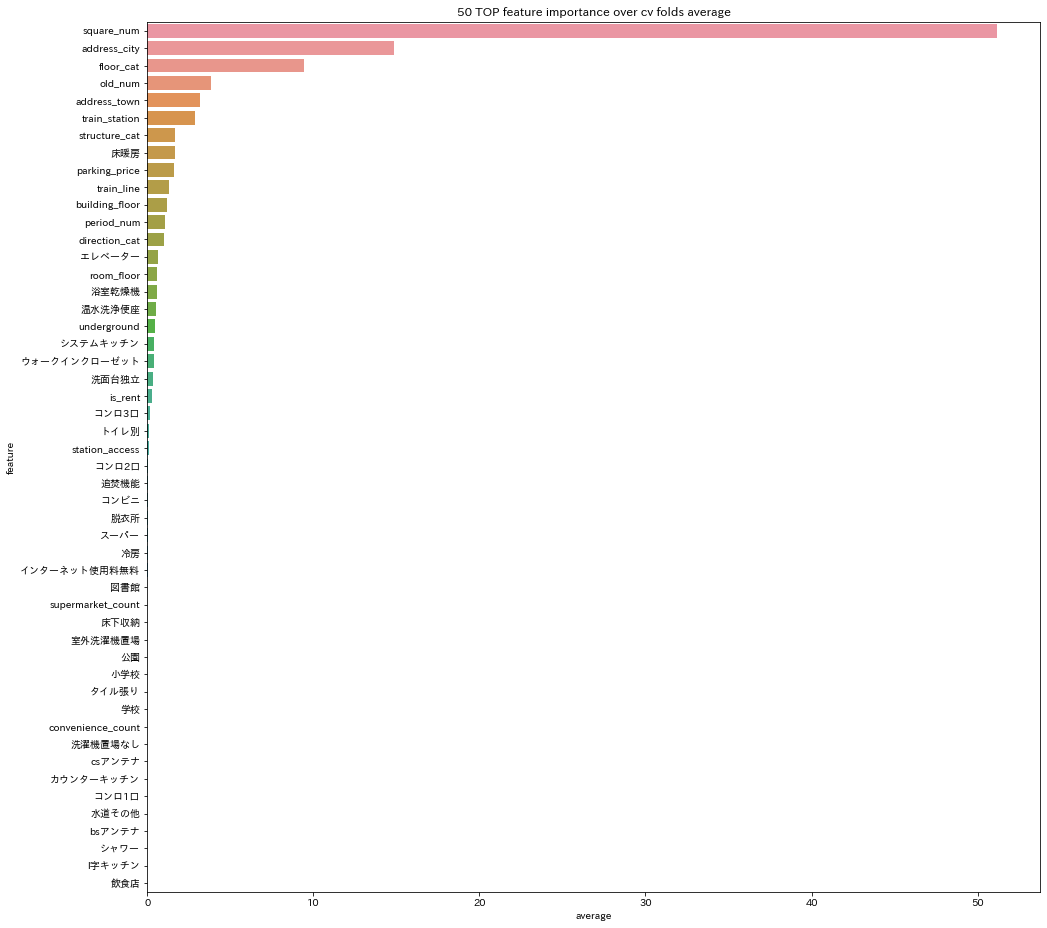

In [117]:
feature_importances['average'] = feature_importances.mean(axis=1)
feature_importances.to_feather('feat1_catboost_importance.ftr')
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title('50 TOP feature importance over cv folds average')
plt.savefig('feat1_catboost_importance.png')

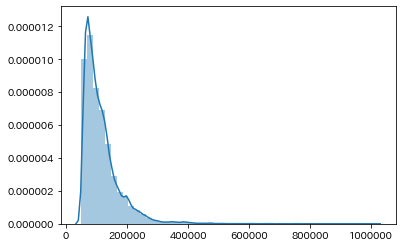

In [119]:
sns.distplot(y_preds)

In [123]:
sub=pd.read_csv('../input/sample_submit.csv',header=None)
sub[1]=y_preds

In [124]:
sub.to_csv('feat1_catboost.csv',header=False,index=False)

(0, 1000000)

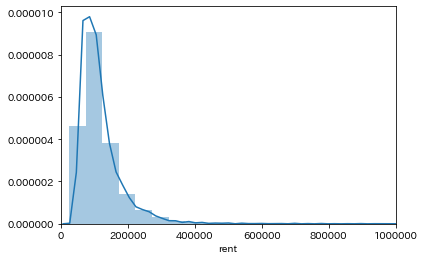

In [122]:
sns.distplot(train['rent'])
plt.xlim(0,1000000)